<a href="https://colab.research.google.com/github/bhattacharyaprafullit/AICTE-Project/blob/main/ProjectEBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Load the Excel file

file_path = '/content/employee_burnout_analysis-AI 2.xlsx'
df = pd.read_excel(file_path)
original_df = df.copy()

# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Employee ID           22750 non-null  object        
 1   Date of Joining       22750 non-null  datetime64[ns]
 2   Gender                22750 non-null  object        
 3   Company Type          22750 non-null  object        
 4   WFH Setup Available   22750 non-null  object        
 5   Designation           22750 non-null  int64         
 6   Resource Allocation   21369 non-null  float64       
 7   Mental Fatigue Score  20633 non-null  float64       
 8   Burn Rate             21626 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.6+ MB
None


In [2]:
print("\nMissing Values:\n", df.isnull().sum())

# Identify numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Fill missing values
# Fill numerical missing values with median
for col in numerical_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical missing values with mode
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)



Missing Values:
 Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64


<ipython-input-2-ab625ef3350d>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-2-ab625ef3350d>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [3]:
columns_to_normalize = ['Mental Fatigue Score', 'Burn Rate']
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Create burnout score
df['burnout_score'] = df['Mental Fatigue Score'] + df['Burn Rate']



In [4]:
clustering_features = ['burnout_score', 'Mental Fatigue Score', 'Burn Rate']
X = df[clustering_features].dropna()

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df.loc[X.index, 'burnout_risk_group'] = kmeans.fit_predict(X)

# Map cluster numbers to risk levels
risk_mapping = {0: 'Low Risk', 1: 'Moderate Risk', 2: 'High Risk'}
df['burnout_risk'] = df['burnout_risk_group'].map(risk_mapping)

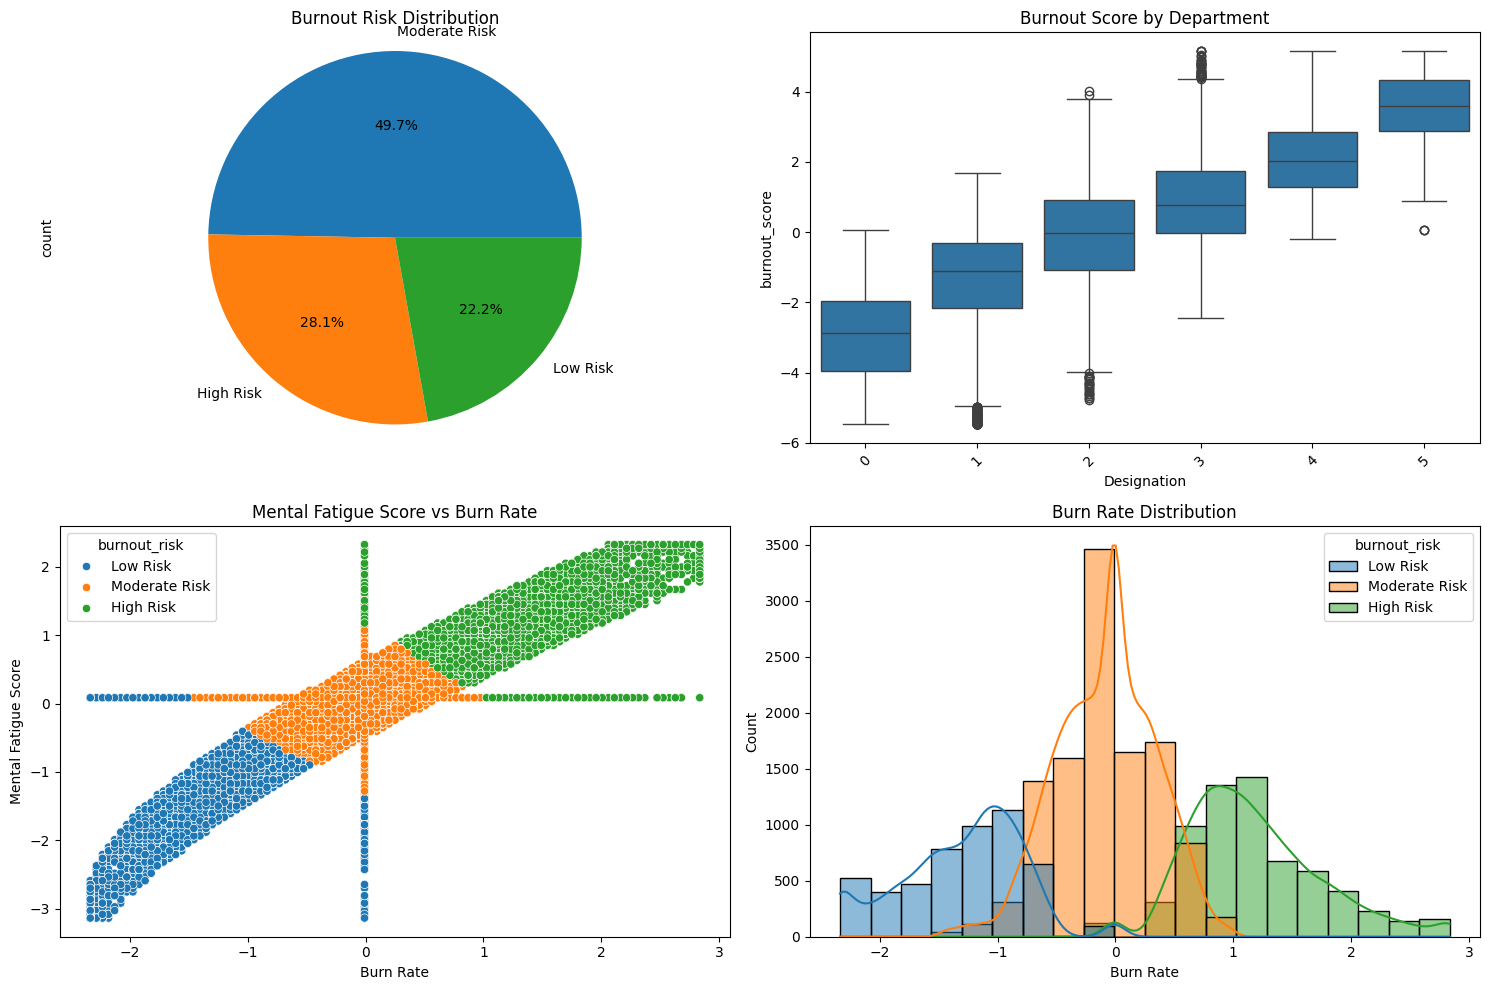

In [5]:
plt.figure(figsize=(15, 10))

# Burnout Risk Distribution Pie Chart
plt.subplot(2, 2, 1)
df['burnout_risk'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Burnout Risk Distribution')
plt.axis('equal')

# Burnout Score by Department
plt.subplot(2, 2, 2)
sns.boxplot(x='Designation', y='burnout_score', data=df)
plt.title('Burnout Score by Department')
plt.xticks(rotation=45)

# Mental Fatigue Score vs Burn Rate Scatter Plot
plt.subplot(2, 2, 3)
sns.scatterplot(x='Burn Rate', y='Mental Fatigue Score', hue='burnout_risk', data=df)
plt.title('Mental Fatigue Score vs Burn Rate')
plt.xlabel('Burn Rate')
plt.ylabel('Mental Fatigue Score')

# Burn Rate Distribution Histogram
plt.subplot(2, 2, 4)
sns.histplot(data=df, x='Burn Rate', hue='burnout_risk', kde=True, bins=20)
plt.title('Burn Rate Distribution')
plt.xlabel('Burn Rate')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [6]:
print("\n--- EMPLOYEE BURNOUT ANALYSIS REPORT ---")

# Overall Statistics
print("\nOverall Burnout Risk Statistics:")
print(df['burnout_risk'].value_counts(normalize=True) * 100)

# Department-wise Analysis
print("\nBurnout Risk by Department:")
dept_burnout = df.groupby('Designation')['burnout_risk'].value_counts(normalize=True).unstack()
print(dept_burnout * 100)

# Correlation Insights
correlation_columns = ['burnout_score', 'Mental Fatigue Score', 'Burn Rate']
print("\nCorrelation Matrix:")
print(df[correlation_columns].corr())


--- EMPLOYEE BURNOUT ANALYSIS REPORT ---

Overall Burnout Risk Statistics:
burnout_risk
Moderate Risk    49.714286
High Risk        28.118681
Low Risk         22.167033
Name: proportion, dtype: float64

Burnout Risk by Department:
burnout_risk  High Risk   Low Risk  Moderate Risk
Designation                                      
0                   NaN  89.449237      10.550763
1              1.208769  42.122516      56.668715
2             20.413811  19.530838      60.055351
3             40.668338   2.623225      56.708438
4             82.057716        NaN      17.942284
5             98.743719        NaN       1.256281

Correlation Matrix:
                      burnout_score  Mental Fatigue Score  Burn Rate
burnout_score              1.000000              0.968995   0.968995
Mental Fatigue Score       0.968995              1.000000   0.877903
Burn Rate                  0.968995              0.877903   1.000000


In [7]:
X = df[['Mental Fatigue Score', 'Burn Rate']].dropna()
y = df['burnout_score'][X.index]

# Linear Regression
lr = LinearRegression()
lr.fit(X, y)
print("\nLinear Regression:")
print(f"Coefficients: {lr.coef_}")
print(f"Intercept: {lr.intercept_}")
print(f"R-squared: {lr.score(X, y)}")

# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X, y)
print("\nDecision Tree Regressor:")
print(f"Feature Importances: {dtr.feature_importances_}")
print(f"R-squared: {dtr.score(X, y)}")

# Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X, y)
print("\nRandom Forest Regressor:")
print(f"Feature Importances: {rfr.feature_importances_}")
print(f"R-squared: {rfr.score(X, y)}")


Linear Regression:
Coefficients: [1. 1.]
Intercept: -2.810938295314706e-18
R-squared: 1.0

Decision Tree Regressor:
Feature Importances: [0.24098664 0.75901336]
R-squared: 1.0

Random Forest Regressor:
Feature Importances: [0.23816087 0.76183913]
R-squared: 0.9999996825545382
